In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Cell 2 – Load & Prepare Dataset
This cell loads the housing dataset, assigns column names, and separates features (X) and target values (y).

In [12]:

# Column names for Boston Housing dataset
cols = [
    'CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS',
    'RAD','TAX','PTRATIO','B','LSTAT','MEDV'
]

# Load space-separated data
data = pd.read_csv("housing.csv", sep=r"\s+", header=None)
data.columns = cols

# Select features and target
X = data[['RM', 'CRIM']].values
y = data['MEDV'].values.reshape(-1, 1)

# Normalize
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()

# Train-test split (80-20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


#Cell 3 – Train–Test Split & Normalization

This cell splits the data into training and testing sets and scales the features so that all values are in a similar range

In [13]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def mse(y, y_hat):
    return np.mean((y - y_hat) ** 2)


#Cell 4 – Neural Network Class

This cell defines a neural network from scratch, including forward propagation, backpropagation, and weight update logic using different optimizers.

In [14]:
class NeuralNetwork:
    def __init__(self, lr=0.01, optimizer="gd"):
        self.lr = lr
        self.optimizer = optimizer

        # Weight initialization
        self.W1 = np.random.randn(2, 5) * 0.01
        self.b1 = np.zeros((1, 5))

        self.W2 = np.random.randn(5, 3) * 0.01
        self.b2 = np.zeros((1, 3))

        self.W3 = np.random.randn(3, 1) * 0.01
        self.b3 = np.zeros((1, 1))

        # Optimizer parameters
        self.v = {}
        self.m = {}
        self.t = 0

        for key in ['W1','b1','W2','b2','W3','b3']:
            self.v[key] = np.zeros_like(getattr(self, key))
            self.m[key] = np.zeros_like(getattr(self, key))

    # Forward propagation
    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = np.maximum(0, self.Z1)

        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = np.maximum(0, self.Z2)

        self.Z3 = self.A2 @ self.W3 + self.b3
        return self.Z3

    # Backpropagation
    def backward(self, X, y, y_hat):
        m = len(X)

        dZ3 = (y_hat - y) / m
        dW3 = self.A2.T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * (self.Z2 > 0)
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * (self.Z1 > 0)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        return {
            'W1': dW1, 'b1': db1,
            'W2': dW2, 'b2': db2,
            'W3': dW3, 'b3': db3
        }

    # Weight update step
    def update(self, grads):
        self.t += 1
        beta1, beta2, eps = 0.9, 0.999, 1e-8

        for key in grads:
            if self.optimizer == "gd":
                setattr(self, key,
                        getattr(self, key) - self.lr * grads[key])

            elif self.optimizer == "momentum":
                self.v[key] = beta1 * self.v[key] + self.lr * grads[key]
                setattr(self, key,
                        getattr(self, key) - self.v[key])

            elif self.optimizer == "adam":
                self.m[key] = beta1 * self.m[key] + (1 - beta1) * grads[key]
                self.v[key] = beta2 * self.v[key] + (1 - beta2) * (grads[key] ** 2)

                m_hat = self.m[key] / (1 - beta1 ** self.t)
                v_hat = self.v[key] / (1 - beta2 ** self.t)

                setattr(self, key,
                        getattr(self, key) - self.lr * m_hat / (np.sqrt(v_hat) + eps))


#Cell 5 – Training Function

This cell trains the neural network for multiple epochs and updates weights to minimize prediction error.

In [15]:
def train(model, X, y, epochs=1000):
    losses = []
    for _ in range(epochs):
        y_hat = model.forward(X)
        loss = mse(y, y_hat)
        losses.append(loss)

        grads = model.backward(X, y, y_hat)
        model.update(grads)
    return losses


#Cell 6 – Model Evaluation

This cell tests the trained model on unseen data and calculates the error to check performance

In [16]:
models = {
    "GD": NeuralNetwork(0.01, "gd"),
    "Momentum": NeuralNetwork(0.01, "momentum"),
    "Adam": NeuralNetwork(0.01, "adam")
}

history = {}
for name, model in models.items():
    history[name] = train(model, X_train, y_train)


#Cell 7 – Optimizer Comparison

This cell compares Gradient Descent, Momentum, and Adam by observing loss reduction and convergence speed.

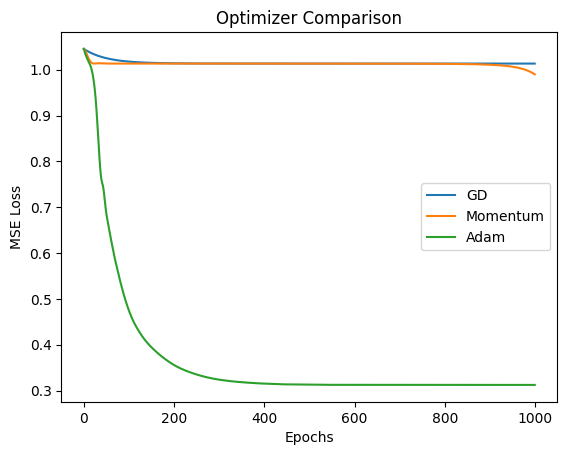

In [ ]:
for name, loss in history.items():
    plt.plot(loss, label=name)

plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Optimizer Comparison")
plt.show()


#Cell 8 – Results & Observations

This cell summarizes which optimizer performs best and explains why based on training behavior.


--- Optimizer Test MSE Comparison ---
GD Test MSE: 1.1054
Momentum Test MSE: 1.0711
Adam Test MSE: 0.3595

Best Optimizer : Adam
Worst Optimizer: GD


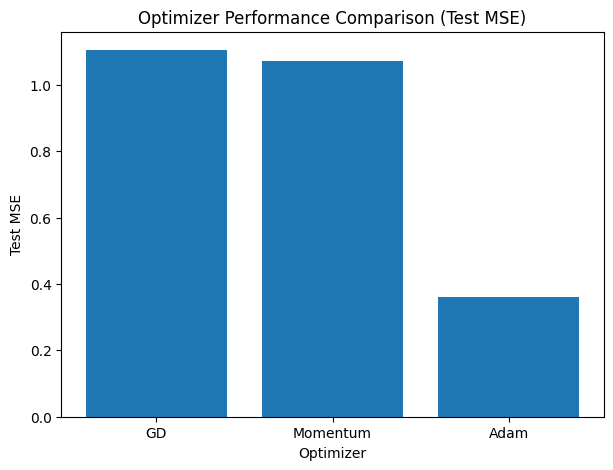

In [50]:
print("\n--- Optimizer Test MSE Comparison ---")
test_results = {}

for name, model in models.items():
    y_pred = model.forward(X_test)
    test_results[name] = mse(y_test, y_pred)
    print(f"{name} Test MSE: {test_results[name]:.4f}")

best = min(test_results, key=test_results.get)
worst = max(test_results, key=test_results.get)

print("\nBest Optimizer :", best)
print("Worst Optimizer:", worst)

# Bar graph for optimizer comparison
plt.figure(figsize=(7,5))
plt.bar(test_results.keys(), test_results.values())
plt.ylabel("Test MSE")
plt.xlabel("Optimizer")
plt.title("Optimizer Performance Comparison (Test MSE)")
plt.show()



#Cell 9 - Actual vs  Predicted House Prices

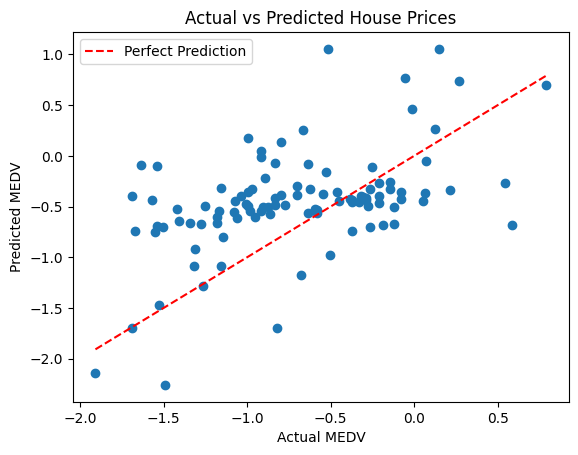

In [19]:

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted House Prices")
plt.legend()
plt.show()

#Cell 10- Experiment with different learning rates (e.g., 0.01, 0.001) to observe the effects on model Training performance

In [43]:
learning_rates = [0.01, 0.001, 0.0001]
predictions = {}
loss_history = {}

for lr in learning_rates:
    model = NeuralNetwork(lr=lr, optimizer="adam")
    loss_history[lr] = train(model, X_train, y_train, epochs=1000)
    predictions[lr] = model.forward(X_test)


Learning Rate 0.01 → Final Training Loss = 0.287173
Learning Rate 0.001 → Final Training Loss = 0.345876
Learning Rate 0.0001 → Final Training Loss = 0.933379

--- Learning Rate Comparison (Training Loss) ---
Best Learning Rate  : 0.01  (Loss = 0.287173)
Worst Learning Rate : 0.0001 (Loss = 0.933379)


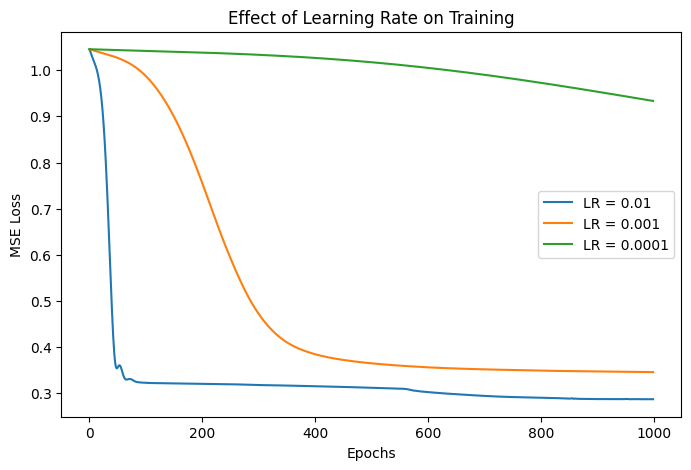

In [47]:

lr_train_loss = {}

for lr, losses in loss_history.items():
    final_loss = losses[-1]   # loss at last epoch
    lr_train_loss[lr] = final_loss
    print(f"Learning Rate {lr} → Final Training Loss = {final_loss:.6f}")

best_lr = min(lr_train_loss, key=lr_train_loss.get)
worst_lr = max(lr_train_loss, key=lr_train_loss.get)

print("\n--- Learning Rate Comparison (Training Loss) ---")
print(f"Best Learning Rate  : {best_lr}  (Loss = {lr_train_loss[best_lr]:.6f})")
print(f"Worst Learning Rate : {worst_lr} (Loss = {lr_train_loss[worst_lr]:.6f})")


plt.figure(figsize=(8,5))

for lr, losses in loss_history.items():
    plt.plot(losses, label=f"LR = {lr}")

plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Effect of Learning Rate on Training")
plt.legend()
plt.show()


#Cell 11-Testing / generalization performance

Learning Rate 0.01 → Test MSE = 0.3441
Learning Rate 0.001 → Test MSE = 0.4271
Learning Rate 0.0001 → Test MSE = 0.6330

--- Learning Rate Comparison Result ---
Best Learning Rate  : 0.01  (MSE = 0.3441)
Worst Learning Rate : 0.0001 (MSE = 0.6330)


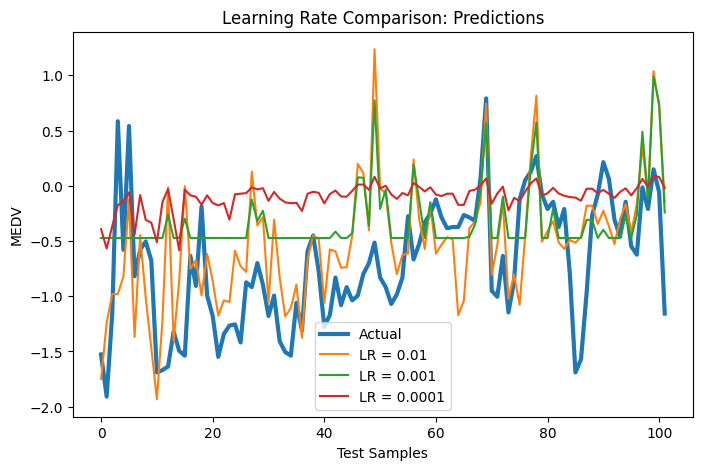

In [46]:

lr_test_mse = {}

for lr, y_pred in predictions.items():
    lr_test_mse[lr] = mse(y_test, y_pred)
    print(f"Learning Rate {lr} → Test MSE = {lr_test_mse[lr]:.4f}")

best_lr = min(lr_test_mse, key=lr_test_mse.get)
worst_lr = max(lr_test_mse, key=lr_test_mse.get)

print("\n--- Learning Rate Comparison Result ---")
print(f"Best Learning Rate  : {best_lr}  (MSE = {lr_test_mse[best_lr]:.4f})")
print(f"Worst Learning Rate : {worst_lr} (MSE = {lr_test_mse[worst_lr]:.4f})")


plt.figure(figsize=(8,5))
plt.plot(y_test, label="Actual", linewidth=3)

for lr, y_pred in predictions.items():
    plt.plot(y_pred, label=f"LR = {lr}")

plt.xlabel("Test Samples")
plt.ylabel("MEDV")
plt.title("Learning Rate Comparison: Predictions")
plt.legend()
plt.show()


#BONUS QUESTIONS

In [51]:
class NeuralNetwork3Hidden:
    def __init__(self, lr=0.01, optimizer="adam"):
        self.lr = lr
        self.optimizer = optimizer

        self.W1 = np.random.randn(2, 5) * 0.01
        self.b1 = np.zeros((1, 5))

        self.W2 = np.random.randn(5, 3) * 0.01
        self.b2 = np.zeros((1, 3))

        self.W3 = np.random.randn(3, 2) * 0.01
        self.b3 = np.zeros((1, 2))

        self.W4 = np.random.randn(2, 1) * 0.01
        self.b4 = np.zeros((1, 1))

        self.m, self.v, self.t = {}, {}, 0
        for k in ['W1','b1','W2','b2','W3','b3','W4','b4']:
            self.m[k] = np.zeros_like(getattr(self, k))
            self.v[k] = np.zeros_like(getattr(self, k))

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = relu(self.Z1)

        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = relu(self.Z2)

        self.Z3 = self.A2 @ self.W3 + self.b3
        self.A3 = relu(self.Z3)

        self.Z4 = self.A3 @ self.W4 + self.b4
        return self.Z4

    def backward(self, X, y, y_hat):
        m = len(X)

        dZ4 = (y_hat - y) / m
        dW4 = self.A3.T @ dZ4
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        dA3 = dZ4 @ self.W4.T
        dZ3 = dA3 * relu_derivative(self.Z3)
        dW3 = self.A2.T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * relu_derivative(self.Z2)
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        return {'W1':dW1,'b1':db1,'W2':dW2,'b2':db2,
                'W3':dW3,'b3':db3,'W4':dW4,'b4':db4}

    def update(self, grads):
        self.t += 1
        beta1, beta2, eps = 0.9, 0.999, 1e-8

        for k in grads:
            self.m[k] = beta1*self.m[k] + (1-beta1)*grads[k]
            self.v[k] = beta2*self.v[k] + (1-beta2)*(grads[k]**2)
            m_hat = self.m[k]/(1-beta1**self.t)
            v_hat = self.v[k]/(1-beta2**self.t)
            setattr(self, k, getattr(self,k) - self.lr*m_hat/(np.sqrt(v_hat)+eps))


#1. Additional Hidden Layers: 
- Add a third hidden layer with 2 neurons and observe the impact on model 
performance. 

In [64]:
model_3h = NeuralNetwork3Hidden()
train(model_3h, X_train, y_train)

y_pred_3h = model_3h.forward(X_test)

# Architecture details
input_size  = model_3h.W1.shape[0]
h1_size     = model_3h.W1.shape[1]
h2_size     = model_3h.W2.shape[1]
h3_size     = model_3h.W3.shape[1]
output_size = model_3h.W4.shape[1]

print("Model Architecture : Neural Network")
print("Input Layer Size   :", input_size)
print("Hidden Layers      : 3")
print("Layer Structure    :",
      input_size, "→",
      h1_size, "→",
      h2_size, "→",
      h3_size, "→",
      output_size)
print("Output Layer Size  :", output_size)
print("Test MSE           :", round(mse(y_test, y_pred_3h), 4))


Model Architecture : Neural Network
Input Layer Size   : 2
Hidden Layers      : 3
Layer Structure    : 2 → 5 → 3 → 2 → 1
Output Layer Size  : 1
Test MSE           : 0.711


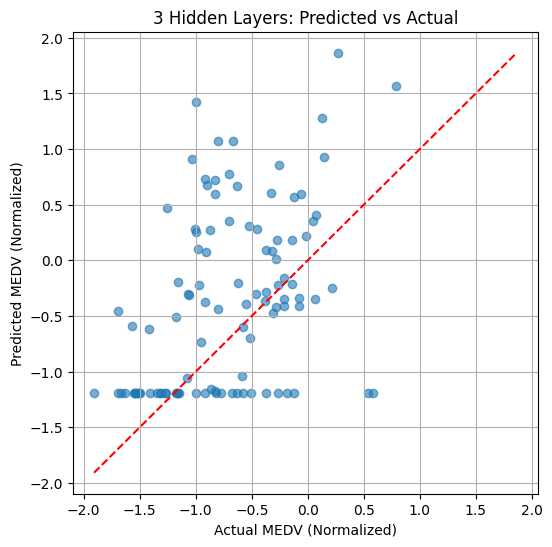

In [66]:
y_pred_3h = model_3h.forward(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_3h, alpha=0.6)

# Perfect prediction reference line
min_val = min(y_test.min(), y_pred_3h.min())
max_val = max(y_test.max(), y_pred_3h.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("Actual MEDV (Normalized)")
plt.ylabel("Predicted MEDV (Normalized)")
plt.title("3 Hidden Layers: Predicted vs Actual")
plt.grid(True)
plt.show()


In [67]:
def backward(self, X, y, y_hat):
    m = len(X)

    dZ3 = (y_hat - y) / m
    dW3 = self.A2.T @ dZ3
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    dA2 = dZ3 @ self.W3.T
    dZ2 = dA2 * relu_derivative(self.Z2)
    dW2 = self.A1.T @ dZ2
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = dZ2 @ self.W2.T
    dZ1 = dA1 * relu_derivative(self.Z1)
    dW1 = X.T @ dZ1
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    # 🔹 L2 Regularization (CORRECT PLACE)
    lambda_l2 = 0.01
    dW3 += lambda_l2 * self.W3
    dW2 += lambda_l2 * self.W2
    dW1 += lambda_l2 * self.W1

    return {
        'W1': dW1, 'b1': db1,
        'W2': dW2, 'b2': db2,
        'W3': dW3, 'b3': db3
    }



In [69]:
model_l2 = NeuralNetwork(lr=0.01, optimizer="adam")
train(model_l2, X_train, y_train)

y_pred_l2 = model_l2.forward(X_test)

# Architecture details (automatically inferred)
input_size  = model_l2.W1.shape[0]
h1_size     = model_l2.W1.shape[1]
h2_size     = model_l2.W2.shape[1]
output_size = model_l2.W3.shape[1]

print("Model Architecture : Neural Network (With L2 Regularization)")
print("Input Layer Size   :", input_size)
print("Hidden Layers      : 2")
print("Layer Structure    :",
      input_size, "→",
      h1_size, "→",
      h2_size, "→",
      output_size)
print("Output Layer Size  :", output_size)
print("L2 Lambda (λ)      : 0.01")
print("Test MSE           :", round(mse(y_test, y_pred_l2), 4))


Model Architecture : Neural Network (With L2 Regularization)
Input Layer Size   : 2
Hidden Layers      : 2
Layer Structure    : 2 → 5 → 3 → 1
Output Layer Size  : 1
L2 Lambda (λ)      : 0.01
Test MSE           : 0.5627


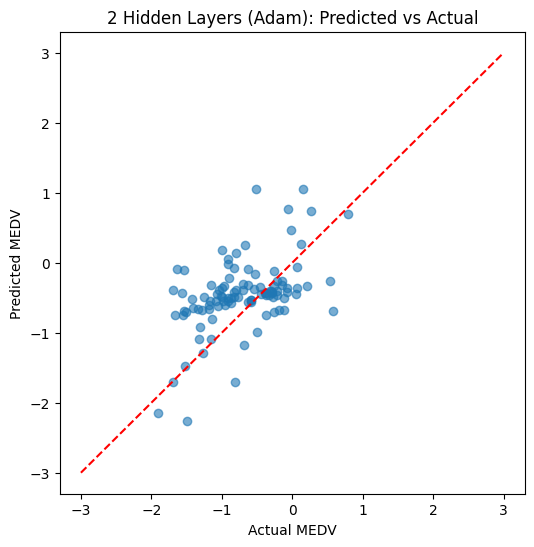

In [70]:
y_pred_2h = models["Adam"].forward(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_2h, alpha=0.6)
plt.plot([-3,3], [-3,3], 'r--')  # ideal line
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("2 Hidden Layers (Adam): Predicted vs Actual")
plt.show()


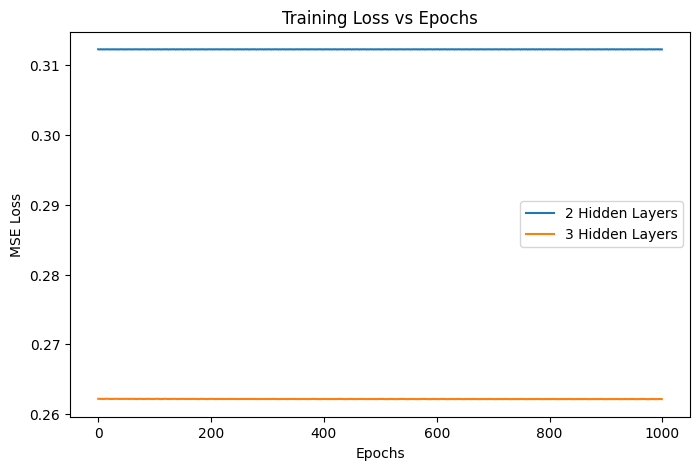

In [73]:
loss_2h = train(models["Adam"], X_train, y_train)
loss_3h = train(model_3h, X_train, y_train)

plt.figure(figsize=(8,5))
plt.plot(loss_2h, label="2 Hidden Layers")
plt.plot(loss_3h, label="3 Hidden Layers")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.show()



--- Model Performance Summary ---
2 Hidden Layers (Adam)    : MSE = 0.3595
3 Hidden Layers           : MSE = 0.7110
Adam + L2                 : MSE = 0.5627

--- Final Comparison ---
Best Model  : 2 Hidden Layers (Adam)  (MSE = 0.3595)
Worst Model : 3 Hidden Layers (MSE = 0.7110)


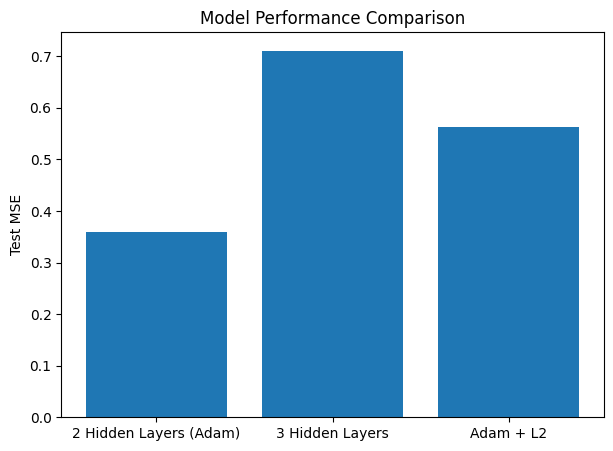

In [75]:
models_mse = {
    "2 Hidden Layers (Adam)": mse(y_test, y_pred_2h),
    "3 Hidden Layers": mse(y_test, y_pred_3h),
    "Adam + L2": mse(y_test, model_l2.forward(X_test))
}

# Print all model performances
print("\n--- Model Performance Summary ---")
for model, value in models_mse.items():
    print(f"{model:25s} : MSE = {value:.4f}")

# Find best and worst
best_model = min(models_mse, key=models_mse.get)
worst_model = max(models_mse, key=models_mse.get)

print("\n--- Final Comparison ---")
print(f"Best Model  : {best_model}  (MSE = {models_mse[best_model]:.4f})")
print(f"Worst Model : {worst_model} (MSE = {models_mse[worst_model]:.4f})")

# Plot
plt.figure(figsize=(7,5))
plt.bar(models_mse.keys(), models_mse.values())
plt.ylabel("Test MSE")
plt.title("Model Performance Comparison")
plt.show()
